# Spectrum Generation

We use the data to generate spectra for the incidence of particles on the detector

In [3]:
#Include modules
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from accelerate import parallel, concat
from tqdm.notebook import tqdm

%matplotlib widget

In [7]:
# Read the files

# Parameters
run                     = 'run0'
header                  = ['EventID','TrackID','Particle','InitialEnergy','DepositedEnergy','XPosition','YPosition','ZPosition','LocalTime','Volume']

# Find the files
foldername  = f'./data/{run}'
filenames   = os.listdir(foldername)

print(f'Found {len(filenames)} data files in {foldername}')

def loadFile(filename):
    return pd.read_csv(os.path.join(foldername,filename),skiprows=14,names=header)

loadFiles = parallel(loadFile)

if __name__ == '__main__':
    files = loadFiles(filenames)

Found 11 data files in ./data/run0


  0%|          | 0/11 [00:00<?, ?it/s]

In [8]:
# Function to extract the energy deposited per track
def getEnergy(data):
    return data.groupby(['EventID','TrackID','Particle'])['DepositedEnergy'].sum().reset_index()

getEnergies = concat(parallel(getEnergy))

# Get the incoming energy of the particles

# Get the deposited energies
energy = getEnergies(files)

# Split into the energy per particle
particleEnergies = {particle:energy.loc[energy.Particle.str.contains(particle)] for particle in energy.Particle.unique()}



  0%|          | 0/11 [00:00<?, ?it/s]

/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


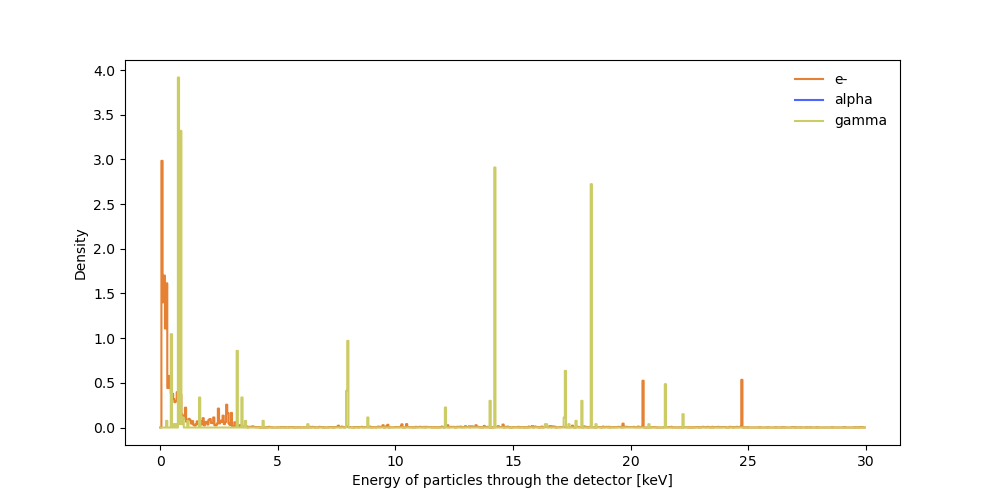

In [55]:
# Plot a histogram
fig = plt.figure(figsize=(10,5))
ax  = fig.add_subplot(111)

NBINS       = 600
LIMS        = (0,30)
BINS        = np.linspace(*LIMS,NBINS+1)
stackedHist = np.array([np.histogram(particleEnergies[particle].DepositedEnergy,bins=BINS,density=True)[0] for particle in particleEnergies])
color       = np.round(np.random.rand(len(stackedHist),3),1)
[ax.step(BINS[:-1],hist,label=particle,color=c) for hist,particle,c in zip(stackedHist,particleEnergies,color)]

# ax.set_xlim(BINS[1],2)
# ax.set_ylim(0,np.max(,axis=0))
ax.set_ylabel('Density')
ax.set_xlabel('Energy of particles through the detector [keV]')
ax.legend(frameon=False)
# ax.set_yscale('log')
# ax.set_xscale('log')
fig.savefig('test.png')

In [38]:
len(particleEnergies['alpha'].DepositedEnergy) /len(energy)

0.33797507308816743

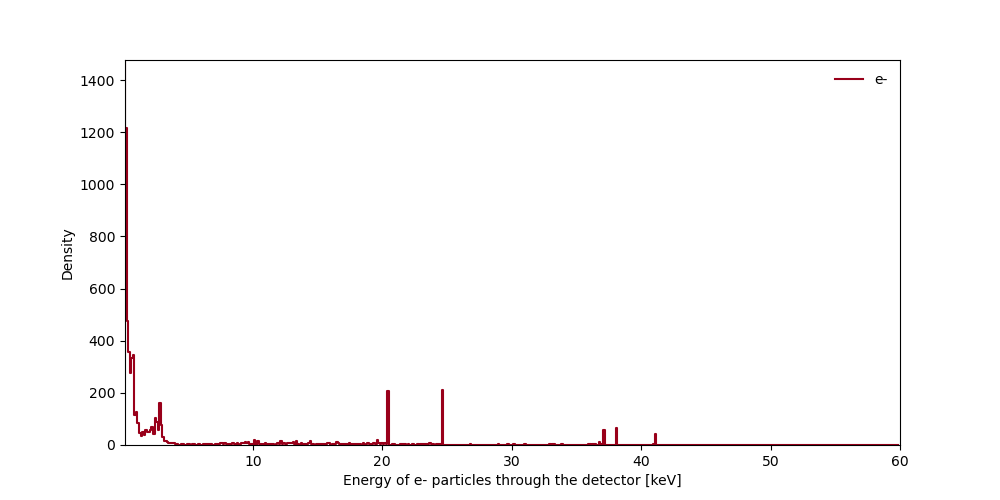

In [61]:
# Plot a histogram
fig = plt.figure(figsize=(10,5))
ax  = fig.add_subplot(111)

NBINS       = 500
LIMS        = (0,60) #(5e3,6e3)
BINS        = np.linspace(*LIMS,NBINS+1)
PARTICLE    = 'e-'
stackedHist = np.histogram(particleEnergies[PARTICLE].DepositedEnergy,bins=BINS)[0]
color       = np.round(np.random.rand(len(stackedHist),3),1)
ax.step(BINS[:-1],stackedHist,label=PARTICLE,color=color[0])

ax.set_xlim(BINS[1],BINS[-1])
ax.set_ylim(0,np.max(stackedHist[1:]))
ax.set_xlabel(f'Energy of {PARTICLE} particles through the detector [keV]')
ax.set_ylabel('Density')
ax.legend(frameon=False)
# ax.set_yscale('log')
# ax.set_xscale('log')

fig.savefig('test.png')